In [1]:
!pip install torchvision

In [2]:
!pip install torchinfo

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 22.6 MB/s eta 0:00:00


In [4]:
import copy
import cv2
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

import torchvision
import torchvision.transforms as transforms
import torchvision.utils

from zipfile import ZipFile

from transformers import AutoImageProcessor, Swinv2Model

# GPU usage settings

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
import os
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths for saving models
CURR_PATH = '/kaggle/working/'
FILE_NAME = os.path.join(CURR_PATH, 'model_seg_pytorch_medical.cnn')
FILE_NAME_PR = os.path.join(CURR_PATH, 'model_segEx_swinV2_medical_21_st.cnn')

# Hyperparameters
r_size = 256
batch_size = 16
ep_num = 20

# Dataset path
DATASET_PATH = '/kaggle/input/mribrain/kaggle_3m'

# Collect all .tif file paths from subdirectories
tif_paths = glob.glob(os.path.join(DATASET_PATH, '**', '*.tif'), recursive=True)

# Build a dictionary: {filename: full_path}
tif_dict = {os.path.basename(p): p for p in tif_paths}

# Define f_images: list of full (image, mask) path pairs
f_images = []
for fname in tif_dict:
    if not fname.endswith('_mask.tif'):
        mask_name = fname[:-4] + '_mask.tif'
        if mask_name in tif_dict:
            f_images.append((tif_dict[fname], tif_dict[mask_name]))

print(f"✅ Total image–mask pairs (f_images): {len(f_images)}")
if f_images:
    print(f"🖼️ Sample pair:\n  Image → {os.path.basename(f_images[0][0])}\n  Mask  → {os.path.basename(f_images[0][1])}")
else:
    print("❌ No valid image–mask pairs found.")




✅ Total image–mask pairs (f_images): 3929
🖼️ Sample pair:
  Image → TCGA_DU_7010_19860307_45.tif
  Mask  → TCGA_DU_7010_19860307_45_mask.tif


In [7]:
def show_input_sample(f_images):
    if not f_images:
        print("❌ No data to show.")
        return

    random.shuffle(f_images)
    img_path, mask_path = f_images[0]

    # Read image using imdecode style
    with open(img_path, 'rb') as f:
        img_data = f.read()
    img = cv2.imdecode(np.frombuffer(img_data, np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Read mask using imdecode style
    with open(mask_path, 'rb') as f:
        mask_data = f.read()
    mask = cv2.imdecode(np.frombuffer(mask_data, np.uint8), 1)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    print(f"🔍 Image: {os.path.basename(img_path)}")
    print(f"🩺 Mask:  {os.path.basename(mask_path)}")
    print(f"Mask stats ➤ Max: {mask.max()}, Min: {mask.min()}, Unique: {np.unique(mask)}")

    # Visualize image and grayscale mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img)
    axes[0].set_title("Image (RGB)")
    axes[1].imshow(mask, cmap='gray')  # Ensures proper grayscale rendering
    axes[1].set_title("Mask (Grayscale)")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


🔍 Image: TCGA_HT_8105_19980826_1.tif
🩺 Mask:  TCGA_HT_8105_19980826_1_mask.tif
Mask stats ➤ Max: 0, Min: 0, Unique: [0]


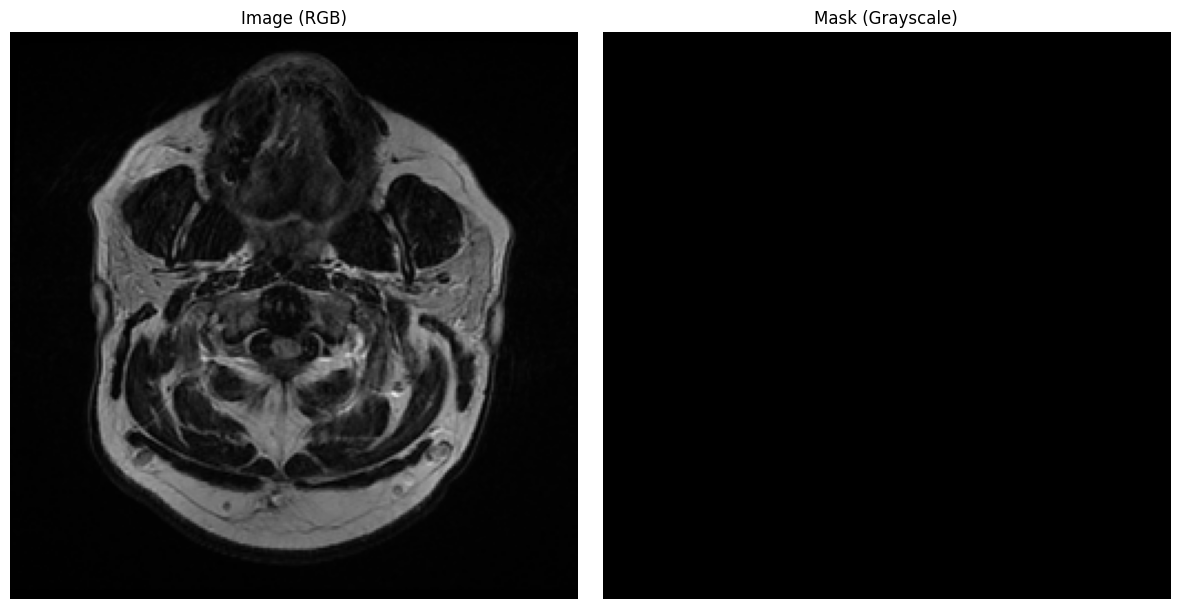

In [8]:
show_input_sample(f_images)

In [9]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-large-patch4-window12-192-22k")
model_seg = Swinv2Model.from_pretrained("microsoft/swinv2-large-patch4-window12-192-22k").to(device)

preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/915M [00:00<?, ?B/s]

#Generation batch with pictures-pairs: source image + mask image

In [10]:
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch
from torchvision import transforms

class SegmentDataset(Dataset):
    def __init__(self,
                 gen_df,
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Resize((r_size, r_size), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
                 ]),
                 mask_color='GRAY'):
        self.gen_df = [item for item in gen_df
                       if "__MACOSX" not in (item if isinstance(item, str) else item[0] and item[1])]
        self.transform = transform
        self.mask_color = mask_color

    def __getitem__(self, index):
        img_name = self.gen_df[index]
        if isinstance(img_name, tuple):  # Handle tuple case for image-mask pairs
            img_name, mask_name = img_name
        else:
            img_name = img_name.strip()
            mask_name = img_name[:-4] + '_mask.tif'

        # Skip __MACOSX
        if "__MACOSX" in img_name or "__MACOSX" in mask_name:
            print(f"Skipping file from __MACOSX directory: {img_name}")
            return self.__getitem__(index + 1 if index + 1 < len(self.gen_df) else 0)

        # --- Load image ---
        img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        if img is None:
            raise IOError(f"Failed to load image: {img_name}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # --- Load mask ---
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE if self.mask_color == 'GRAY' else cv2.IMREAD_COLOR)
        if mask is None:
            raise IOError(f"Failed to load mask: {mask_name}")

        if self.mask_color == 'GRAY':
            if len(mask.shape) > 2:
                mask = mask[:, :, 0]
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # --- Convert to PIL and apply transforms ---
        img_pil = Image.fromarray(img)
        img_in = self.transform(img_pil)

        mask_pil = Image.fromarray(mask)
        mask = self.transform(mask_pil)

        # --- Extract intermediate outputs from model_seg ---
        img_input = image_processor(images=img_pil, return_tensors="pt")

        with torch.no_grad():
            x = model_seg.embeddings(**img_input.to(device))
            input_dimensions = x[1]
            img0 = x[0].squeeze(0)

            x = model_seg.encoder.layers[0](x[0], input_dimensions=input_dimensions)
            img1 = x[0].squeeze(0)

            x = model_seg.encoder.layers[1](x[0], input_dimensions=(input_dimensions[0] // 2, input_dimensions[1] // 2))
            img2 = x[0].squeeze(0)

            x = model_seg.encoder.layers[2](x[0], input_dimensions=(input_dimensions[0] // 4, input_dimensions[1] // 4))
            img3 = x[0].squeeze(0)

            x = model_seg.encoder.layers[3](x[0], input_dimensions=(input_dimensions[0] // 8, input_dimensions[1] // 8))
            x = model_seg.layernorm(x[0])
            img4 = x.squeeze(0)

        return img0, img1, img2, img3, img4, mask, img_in

    def __len__(self):
        return len(self.gen_df)


###Network creation (model, loss function, optimizer)

In [11]:
class Up_Linear(nn.Module):
    def __init__(self, in_ch, size, coef=1):
        super(Up_Linear, self).__init__()
        self.shuffle = nn.PixelShuffle(upscale_factor=2)

        n_ch = int(coef * in_ch)

        self.ln = nn.Sequential(
            nn.Linear(in_ch * 2, n_ch),
            nn.ReLU(inplace=True),
            nn.Linear(n_ch, in_ch * 2),
            nn.ReLU(inplace=True),
        )

        self.size = size

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), 2)
        x = self.ln(x)
        x = x.permute(0, 2, 1)
        x = torch.reshape(x, (x.shape[0], x.shape[1], self.size, self.size))
        x = self.shuffle(x)
        x = torch.reshape(x, (x.shape[0], x.shape[1], self.size*self.size*4))
        x = x.permute(0, 2, 1)
        return x

class MRI_Seg(nn.Module):
    def __init__(self):
        super(MRI_Seg, self).__init__()

        self.ups3 = Up_Linear(1536, 6, 1)
        self.ups2 = Up_Linear(768, 12, 1)
        self.ups1 = Up_Linear(384, 24, 2)
        self.ups0 = Up_Linear(192, 48, 3)

        self.shuffle = nn.PixelShuffle(upscale_factor=2)

        self.out = nn.Sequential(
            nn.Conv2d(24, 1, kernel_size=1, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x0, x1, x2, x3, x4):
        x = self.ups3(x4, x3)
        x = self.ups2(x, x2)
        x = self.ups1(x, x1)
        x = self.ups0(x, x0)

        x = x.permute(0, 2, 1)
        x = torch.reshape(x, (x.shape[0], x.shape[1], 96, 96))
        x = self.shuffle(x)
        x = transforms.Resize((r_size, r_size))(x)

        x = self.out(x)
        return x


In [14]:
from sklearn.model_selection import train_test_split


In [15]:
# Step 1: Use f_images directly – already verified image–mask pairs
image_mask_pairs = f_images

# Step 2: Train-test split (80% train, 20% test)
train_val_pairs, test_pairs = train_test_split(image_mask_pairs, test_size=0.2, random_state=42)

# Step 3: Further split train into train/val (e.g., 80% train, 20% val)
train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=0.2, random_state=42)

# Step 4: Define transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Step 5: Create datasets (assuming SegmentDataset handles tuple of (img_path, mask_path))
train_dataset = SegmentDataset(gen_df=train_val_pairs, transform=transform)
val_dataset   = SegmentDataset(gen_df=val_pairs, transform=transform)
test_dataset  = SegmentDataset(gen_df=test_pairs, transform=transform)

# Step 6: Create dataloaders
batch_size = 8
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0)
val_dataloader   = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, num_workers=0)
test_dataloader  = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=0)


In [16]:

net = MRI_Seg().to(device)

criterion = nn.BCELoss()
lr = 0.0001
optimizer = optim.Adam(net.parameters(), lr=lr)

In [17]:
len(train_dataloader)

393

In [18]:
summary(model=net, input_size=[(1, 2304, 192), (1, 576, 384), (1, 144, 768), (1, 36, 1536), (1, 36, 1536)], col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
MRI_Seg                                  [1, 2304, 192]            [1, 1, 256, 256]          --                        True
├─Up_Linear: 1-1                         [1, 36, 1536]             [1, 144, 768]             --                        True
│    └─Sequential: 2-1                   [1, 36, 3072]             [1, 36, 3072]             --                        True
│    │    └─Linear: 3-1                  [1, 36, 3072]             [1, 36, 1536]             4,720,128                 True
│    │    └─ReLU: 3-2                    [1, 36, 1536]             [1, 36, 1536]             --                        --
│    │    └─Linear: 3-3                  [1, 36, 1536]             [1, 36, 3072]             4,721,664                 True
│    │    └─ReLU: 3-4                    [1, 36, 3072]             [1, 36, 3072]             --                        --
│    └─

###Non-trained network output

In [19]:
net.eval().to(device)

MRI_Seg(
  (ups3): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=3072, out_features=1536, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1536, out_features=3072, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups2): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=1536, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=1536, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups1): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=768, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups0): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=384, 

In [20]:
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

# Make sure net, train_dataloader, and device are already defined
ep_num = 8 # or any number of epochs you want
FILE_NAME = 'MRI_segmentation_model.pth'


In [21]:
net = MRI_Seg().to(device)  # No pretrained weights
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)


In [22]:
import os
from tqdm import tqdm  # ✅ Progress bar for epochs

def train_net():
    num_iter = len(train_dataloader)
    ep_init = 0
    best_loss = float('inf')
    best_model_path = os.path.join("/kaggle/working", f"{FILE_NAME}_best.pt")

    # ✅ Wrap epoch loop with tqdm for progress bar
    for epoch in tqdm(range(ep_init, ep_num), desc="Training Progress", unit="epoch"):
        sum_loss = 0

        for data in train_dataloader:
            img0, img1, img2, img3, img4, mask, img_in = data

            optimizer.zero_grad()

            x0 = img0.to(device)
            x1 = img1.to(device)
            x2 = img2.to(device)
            x3 = img3.to(device)
            x4 = img4.to(device)

            output = net(x0, x1, x2, x3, x4)

            loss_bce = criterion(output, mask.to(device))
            loss_bce.backward()
            optimizer.step()

            sum_loss += loss_bce.item()

        avg_loss = sum_loss / num_iter
        print(f"\n📊 Epoch [{epoch + 1}/{ep_num}] | Avg Loss: {avg_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model based on lowest loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(net, best_model_path)
            print(f"✅ Best model updated and saved at: {best_model_path}")

    print("\n🎯 Training complete.")
    print(f"📁 Best model saved at: {best_model_path}")
    print(f"🔗 [Download Link]({best_model_path})")


In [23]:
train_net()


Training Progress:  12%|█▎        | 1/8 [02:58<20:50, 178.70s/epoch]


📊 Epoch [1/8] | Avg Loss: 0.059760 | LR: 0.000100
✅ Best model updated and saved at: /kaggle/working/MRI_segmentation_model.pth_best.pt


Training Progress:  25%|██▌       | 2/8 [05:14<15:21, 153.57s/epoch]


📊 Epoch [2/8] | Avg Loss: 0.012363 | LR: 0.000100
✅ Best model updated and saved at: /kaggle/working/MRI_segmentation_model.pth_best.pt


Training Progress:  38%|███▊      | 3/8 [07:30<12:07, 145.60s/epoch]


📊 Epoch [3/8] | Avg Loss: 0.009432 | LR: 0.000100
✅ Best model updated and saved at: /kaggle/working/MRI_segmentation_model.pth_best.pt


Training Progress:  50%|█████     | 4/8 [09:45<09:25, 141.41s/epoch]


📊 Epoch [4/8] | Avg Loss: 0.007909 | LR: 0.000100
✅ Best model updated and saved at: /kaggle/working/MRI_segmentation_model.pth_best.pt


Training Progress:  62%|██████▎   | 5/8 [12:00<06:57, 139.01s/epoch]


📊 Epoch [5/8] | Avg Loss: 0.007034 | LR: 0.000100
✅ Best model updated and saved at: /kaggle/working/MRI_segmentation_model.pth_best.pt


Training Progress:  75%|███████▌  | 6/8 [14:15<04:35, 137.80s/epoch]


📊 Epoch [6/8] | Avg Loss: 0.006286 | LR: 0.000100
✅ Best model updated and saved at: /kaggle/working/MRI_segmentation_model.pth_best.pt


Training Progress:  88%|████████▊ | 7/8 [16:30<02:16, 136.84s/epoch]


📊 Epoch [7/8] | Avg Loss: 0.005508 | LR: 0.000100
✅ Best model updated and saved at: /kaggle/working/MRI_segmentation_model.pth_best.pt


Training Progress: 100%|██████████| 8/8 [18:44<00:00, 140.60s/epoch]


📊 Epoch [8/8] | Avg Loss: 0.005023 | LR: 0.000100
✅ Best model updated and saved at: /kaggle/working/MRI_segmentation_model.pth_best.pt

🎯 Training complete.
📁 Best model saved at: /kaggle/working/MRI_segmentation_model.pth_best.pt
🔗 [Download Link](/kaggle/working/MRI_segmentation_model.pth_best.pt)


In [36]:
import copy
import cv2
import matplotlib.pyplot as plt
from torch.autograd import Variable

def calc_rect(img_mask):
    ind = np.argwhere(img_mask >= 0.5)
    if len(ind) == 0:
        return None, None
    top_y = min(ind[:, 0])
    bottom_y = max(ind[:, 0])
    top_x = min(ind[:, 1])
    bottom_x = max(ind[:, 1])
    return (top_x, top_y), (bottom_x, bottom_y)

def show_results(i0, i1, i2, i3, i4, y, x1, im_id):
    ii0 = Variable(i0).to(device)
    ii1 = Variable(i1).to(device)
    ii2 = Variable(i2).to(device)
    ii3 = Variable(i3).to(device)
    ii4 = Variable(i4).to(device)

    net.eval()  # Ensure the model is in eval mode
    with torch.no_grad():
        pred = net(ii0, ii1, ii2, ii3, ii4)
    pr = pred[im_id].cpu().numpy()[0]

    xim = copy.deepcopy(x1[im_id].permute(1, 2, 0).cpu().numpy())
    xim = cv2.resize(xim, (r_size, r_size))  # resize if needed

    top_left, bottom_right = calc_rect(pr)
    if top_left is not None:
        cv2.rectangle(xim, top_left, bottom_right, (255, 0, 0), 2)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(y[im_id].cpu().numpy()[0], cmap='gray')
    axes[1].imshow(pr > 0.5, cmap='gray')
    axes[2].imshow(xim)
    plt.show()


In [25]:
net.eval().to(device)

MRI_Seg(
  (ups3): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=3072, out_features=1536, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1536, out_features=3072, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups2): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=1536, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=1536, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups1): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=768, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups0): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=384, 

In [26]:
test_dataloader1 = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1)


test_dataloader2 = DataLoader(test_dataset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)

In [27]:
dataiter = iter(test_dataloader1)

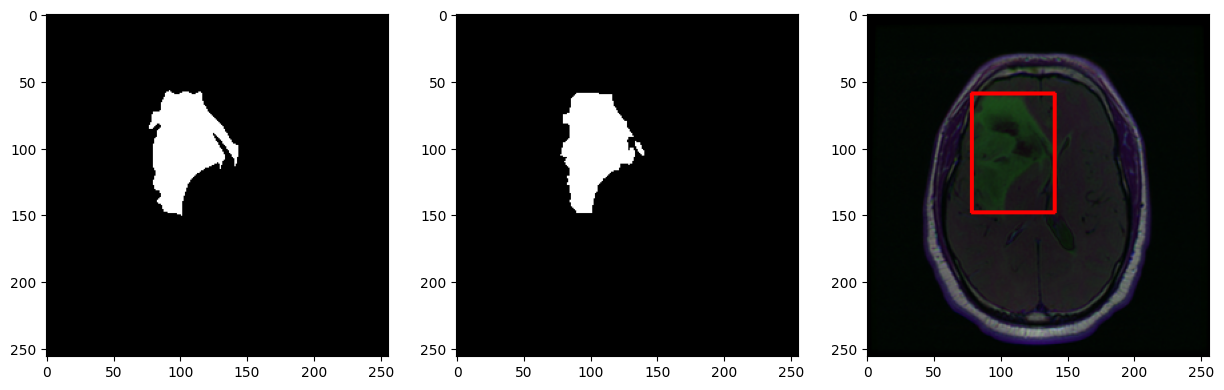

In [28]:
i0, i1, i2, i3, i4, y, x1 = next(dataiter)
show_results(i0, i1, i2, i3, i4, y, x1, 0)

In [29]:
dataiter2 = iter(test_dataloader2)

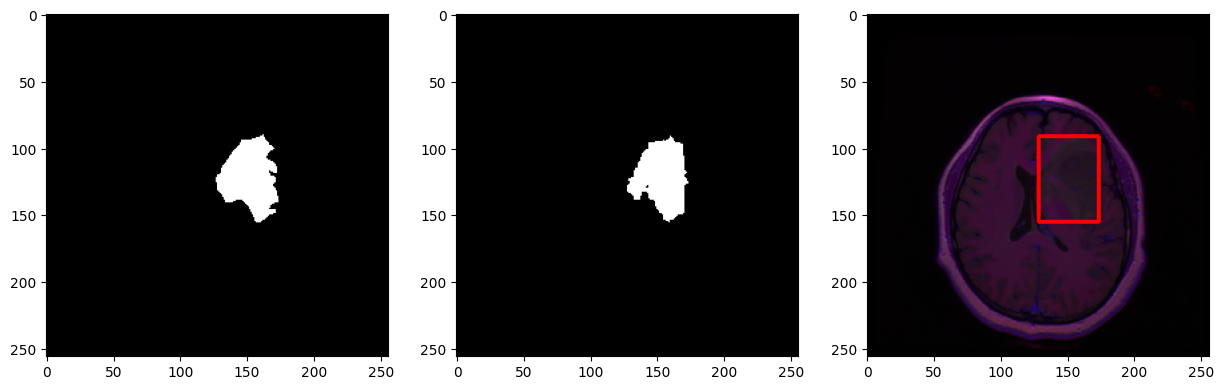

In [30]:
i0, i1, i2, i3, i4, y, x1 = next(dataiter2)
show_results(i0, i1, i2, i3, i4, y, x1, 0)

In [31]:
def calc_accuracy(test_dataloader, set_id, model, sample_num=None):
    batch_size = 1
    if not sample_num:
        N = len(test_dataloader)
    else:
        if sample_num <= 0:
            sample_num = len(test_dataloader)
        N = min(sample_num, len(test_dataloader))

    And = 0
    Uni = 0
    Uni_dice = 0
    IoU_Pic_mean = 0
    calc_mask = 0

    T0 = 0
    T1 = 0
    F0 = 0
    F1 = 0

    for i, data in enumerate(test_dataloader, 0):
        img0, img1, img2, img3, img4, yy, xs = data

        x0 = Variable(img0).to(device)
        x1 = Variable(img1).to(device)
        x2 = Variable(img2).to(device)
        x3 = Variable(img3).to(device)
        x4 = Variable(img4).to(device)

        with torch.no_grad():
            xx1 = model(x0, x1, x2, x3, x4)
        xx1 = xx1[0][0].cpu().detach().numpy()
        yy = yy[0][0].cpu().detach().numpy()
        xx1[xx1 >= 0.5] = 1
        xx1[xx1 < 0.5] = 0

        owl = np.sum(xx1 * yy)
        And += owl
        a_uni_dice = np.sum(xx1 + yy)
        a_uni = a_uni_dice - owl
        Uni += a_uni
        Uni_dice += a_uni_dice

        if a_uni > 0:
            calc_mask += 1
            IoU_Pic = owl / a_uni
            IoU_Pic_mean += IoU_Pic
            if yy.max() == 0:
                F1 += 1
            else:
                if xx1.max() == 0:
                    F0 += 1
                else:
                    T1 += 1
        else:
            T0 += 1

        # Removed: print('{}:  i = {}, And = {}, Uni = {}'.format(set_id, i, And, Uni))

        if i >= N - 1:
            break

    IoU_av = And / Uni
    Dice = 2 * And / Uni_dice
    if calc_mask > 0:
        IoU_Pic_mean = IoU_Pic_mean / calc_mask

    recall = T1 / (T1 + F0 + 1e-8)
    precision = T1 / (T1 + F1 + 1e-8)
    F_measure = (2 * recall * precision) / (recall + precision + 1e-8)

    print(f"\n--- {set_id.upper()} METRICS ---")
    print(f"IoU Average     : {IoU_av:.4f}")
    print(f"IoU Pic Mean    : {IoU_Pic_mean:.4f}")
    print(f"F-measure       : {F_measure:.4f}")
    print(f"Dice Coefficient: {Dice:.4f}")
    print(f"T0 = {T0}, T1 = {T1}, F0 = {F0}, F1 = {F1}\n")

    return IoU_av, IoU_Pic_mean, F_measure, Dice


In [32]:
IoU_tr, IoU_Pic_mean_tr, F_measure_tr, Dice_tr = calc_accuracy(test_dataloader1, 'train', net, sample_num=550)


--- TRAIN METRICS ---
IoU Average     : 0.8411
IoU Pic Mean    : 0.7152
F-measure       : 0.9522
Dice Coefficient: 0.9137
T0 = 331, T1 = 199, F0 = 6, F1 = 14



In [33]:
print('training set: IoU = {}, IoU_pic_mean = {}, F_measure = {}, Dice = {}'.format(IoU_tr, IoU_Pic_mean_tr, F_measure_tr, Dice_tr))

training set: IoU = 0.8411143200962695, IoU_pic_mean = 0.7151699396845412, F_measure = 0.9521531050041208, Dice = 0.9137013502260835


In [34]:
IoU_ts, IoU_Pic_mean_ts, F_measure_ts, Dice_ts = calc_accuracy(test_dataloader2, 'test', net)


--- TEST METRICS ---
IoU Average     : 0.7620
IoU Pic Mean    : 0.6123
F-measure       : 0.9393
Dice Coefficient: 0.8649
T0 = 480, T1 = 271, F0 = 15, F1 = 20



In [35]:
print('test set: IoU = {}, IoU_pic_mean = {}, F_measure = {}, Dice = {}'.format(IoU_ts, IoU_Pic_mean_ts, F_measure_ts, Dice_ts))

test set: IoU = 0.7619692805998508, IoU_pic_mean = 0.6123046710679393, F_measure = 0.9393414161116634, Dice = 0.8649064305371356
